In [1]:
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam, SGD
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Reshape, BatchNormalization, Activation, LeakyReLU, Input, GaussianNoise
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import UpSampling2D
from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
import random
import cv2
import glob
import os

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# For reproducibility
np.random.seed(42)

In [3]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    cropped_img = np.copy(img[starty:starty+cropy, startx:startx+cropx, :])
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img[p][k] = (1, 1, 1)
            else:
                img[p][k] = img[p][k]
    return (img, cropped_img)

In [25]:
def build_generator():


    model = Sequential()

    # Encoder
    model.add(Conv2D(32, kernel_size=5, strides=2, input_shape=(256,256,3), padding="same")) # 256 x 256 -> 128 x 128
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))# 128 x 128 -> 64 x 64
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) # 64 x 64 -> 32 x 32
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same")) # 32 x 32 -> 16 x 16
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same")) # 16 x 16 -> 8 x 8
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same")) # 8 x 8 -> 4 x 4
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=1, strides=2, padding="same")) # 4 x 4 -> 2 x 2
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=1, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(2048))
    model.add(Reshape((2,2,512)))


    # Decoder
    model.add(UpSampling2D()) # 2 x 2 -> 4 x 4
    model.add(Conv2D(512, kernel_size=1, padding="same")) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D()) # 4 x 4 -> 8 x 8
    model.add(Conv2D(256, kernel_size=3, padding="same")) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D()) # 8 x 8 -> 16 x 16
    model.add(Conv2D(128, kernel_size=3, padding="same")) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(UpSampling2D()) # 16 x 16 -> 32 x 32
    model.add(Conv2D(64, kernel_size=3, padding="same")) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D()) # 32 x 32 -> 64 x 64
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D()) # 64 x 64 -> 128 x 128
    model.add(Conv2D(16, kernel_size=3, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation('tanh'))

    masked_img = Input(shape=(256,256,3))
    gen_missing = model(masked_img)

    return Model(masked_img, gen_missing)

def build_discriminator():

    model = Sequential()
    #model.add(GaussianNoise(0.1, input_shape=(128,128,3)))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding="same", input_shape=(128,128,3))) # 128 x 128 -> 64 x 64
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same")) # 64 x 64 -> 32 x 32
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) # 32 x 32 -> 16 x 16
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same")) # 16 x 16 -> 8 x 8
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same")) # 8 x 8 -> 4 x 4
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    img = Input(shape=(128,128,3))
    validity = model(img)

    return Model(img, validity)

In [42]:
#d_optim = SGD(lr=0.0005, momentum=0.9, nesterov=True)
d_optim = Adam(lr=1e-4)
g_optim = Adam(lr=1e-3)

model_discriminator = build_discriminator()
#model_discriminator.load_weights('discriminator_places')
model_discriminator.compile(loss='binary_crossentropy',
            optimizer=d_optim,
            metrics=['accuracy'])

model_generator = build_generator()
#model_generator.load_weights('generator_places')
model_generator.compile(loss='mse',
            optimizer=g_optim,
            metrics=['accuracy'])

masked_img = Input(shape=(256,256,3))
gen_missing = model_generator(masked_img)
model_discriminator.trainable = False

valid = model_discriminator(gen_missing)

model_gan = Model(masked_img , [gen_missing, valid])
model_gan.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=g_optim)

In [43]:
def get_images(batch_size, folders, number):
    random_folders = random.sample(folders, batch_size)
    filename = number.zfill(8) + ".jpg"
    images = []
    for f in random_folders:
        img = cv2.imread(os.path.join(f[0],filename))
        if img is not None:
            images.append(img)
    images = np.array(images)
    X = []
    Y = []
    for i in images:
        img = crop_center(i, 128, 128)
        X.append(img[0])
        Y.append(img[1])
    X_array = np.array(X)
    Y_array = np.array(Y)
    X_array = (X_array.astype(np.float32) - 127.5)/127.5
    Y_array = (Y_array.astype(np.float32) - 127.5)/127.5
    return (X_array, Y_array)

In [44]:
folder = "Places/places2/data_256/"
folders = list(os.walk(folder))

def train(train_steps=1000000, batch_size=64):
    for i in range(train_steps):
                
        # ---------------------
        #  Get Images
        # ---------------------
        
        number = str(random.randint(1, 5000))
        X, Y = get_images(batch_size, folders, number)
        
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Random input
        missing_part = Y
        masked_imgs = X
        gen_missing_part = model_generator.predict(masked_imgs)
        
        # Valid and fake outputs (flipping)
        valid = np.ones([X.shape[0], 1])
        fake = np.zeros([X.shape[0], 1])

        # Train discriminator
        d_loss_valid = model_discriminator.train_on_batch(missing_part, valid)
        d_loss_fake = model_discriminator.train_on_batch(gen_missing_part, fake)
        d_loss = 0.5 * np.add(d_loss_valid, d_loss_fake)
        
        # ---------------------
        #  Train Generator
        # ---------------------
        g_loss = model_gan.train_on_batch(masked_imgs, [missing_part, valid])
        
        
        # ---------------------
        #  Logs
        # ---------------------
        if i % 100 == 0:
                model_generator.save_weights('generator_places2', True)
                model_discriminator.save_weights('discriminator_places2', True)
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (i, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

In [ ]:
train()

C:\Users\Marcelo\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.695785, acc: 21.00%] [G loss: 0.755689, mse: 0.755878]
1 [D loss: 0.784589, acc: 50.00%] [G loss: 0.632342, mse: 0.632482]
2 [D loss: 0.854231, acc: 50.00%] [G loss: 0.464189, mse: 0.464146]
3 [D loss: 0.720543, acc: 50.00%] [G loss: 0.364231, mse: 0.364057]
4 [D loss: 0.648278, acc: 50.00%] [G loss: 0.275335, mse: 0.275049]
5 [D loss: 0.568197, acc: 97.17%] [G loss: 0.294144, mse: 0.293874]
6 [D loss: 0.557491, acc: 88.24%] [G loss: 0.259794, mse: 0.259485]
7 [D loss: 0.518503, acc: 90.00%] [G loss: 0.247952, mse: 0.247665]
8 [D loss: 0.502099, acc: 83.96%] [G loss: 0.263101, mse: 0.262882]
9 [D loss: 0.516614, acc: 79.63%] [G loss: 0.252967, mse: 0.252766]
10 [D loss: 0.534487, acc: 75.00%] [G loss: 0.275973, mse: 0.275795]
11 [D loss: 0.534904, acc: 78.12%] [G loss: 0.262041, mse: 0.261860]
12 [D loss: 0.574359, acc: 68.48%] [G loss: 0.239004, mse: 0.238783]
13 [D loss: 0.504269, acc: 75.51%] [G loss: 0.224909, mse: 0.224582]
14 [D loss: 0.452179, acc: 83.00%] [G loss: 

234 [D loss: 0.032304, acc: 98.96%] [G loss: 0.197070, mse: 0.192349]
235 [D loss: 0.031346, acc: 99.06%] [G loss: 0.199159, mse: 0.194157]
236 [D loss: 0.043811, acc: 98.86%] [G loss: 0.175097, mse: 0.170049]
237 [D loss: 0.021534, acc: 99.12%] [G loss: 0.167039, mse: 0.162249]
238 [D loss: 0.039668, acc: 98.00%] [G loss: 0.181916, mse: 0.177608]
239 [D loss: 0.017216, acc: 100.00%] [G loss: 0.176652, mse: 0.172396]
240 [D loss: 0.023004, acc: 99.09%] [G loss: 0.192299, mse: 0.187972]
241 [D loss: 0.074208, acc: 98.04%] [G loss: 0.174288, mse: 0.170137]
242 [D loss: 0.008761, acc: 100.00%] [G loss: 0.176101, mse: 0.171842]
243 [D loss: 0.023380, acc: 99.09%] [G loss: 0.194725, mse: 0.190291]
244 [D loss: 0.012556, acc: 100.00%] [G loss: 0.212467, mse: 0.207514]
245 [D loss: 0.005785, acc: 100.00%] [G loss: 0.175897, mse: 0.170529]
246 [D loss: 0.025088, acc: 99.07%] [G loss: 0.177623, mse: 0.171979]
247 [D loss: 0.049694, acc: 99.06%] [G loss: 0.178773, mse: 0.174217]
248 [D loss: 0.0

466 [D loss: 0.102059, acc: 97.12%] [G loss: 0.167048, mse: 0.162464]
467 [D loss: 0.127209, acc: 94.44%] [G loss: 0.161916, mse: 0.156877]
468 [D loss: 0.004180, acc: 100.00%] [G loss: 0.179121, mse: 0.172950]
469 [D loss: 0.001898, acc: 100.00%] [G loss: 0.189445, mse: 0.182613]
470 [D loss: 0.146393, acc: 96.08%] [G loss: 0.183708, mse: 0.177412]
471 [D loss: 0.083088, acc: 99.06%] [G loss: 0.160332, mse: 0.154961]
472 [D loss: 0.078066, acc: 97.83%] [G loss: 0.182157, mse: 0.177681]
473 [D loss: 0.043247, acc: 97.22%] [G loss: 0.193922, mse: 0.189631]
474 [D loss: 0.030255, acc: 99.02%] [G loss: 0.154352, mse: 0.149882]
475 [D loss: 0.042614, acc: 99.02%] [G loss: 0.171257, mse: 0.166900]
476 [D loss: 0.039340, acc: 99.02%] [G loss: 0.158468, mse: 0.153728]
477 [D loss: 0.063367, acc: 98.98%] [G loss: 0.177862, mse: 0.172919]
478 [D loss: 0.018321, acc: 99.02%] [G loss: 0.181749, mse: 0.176670]
479 [D loss: 0.058549, acc: 98.96%] [G loss: 0.157999, mse: 0.153033]
480 [D loss: 0.023

698 [D loss: 0.021575, acc: 100.00%] [G loss: 0.178929, mse: 0.175209]
699 [D loss: 0.085803, acc: 98.11%] [G loss: 0.178226, mse: 0.174723]
700 [D loss: 0.028105, acc: 100.00%] [G loss: 0.179466, mse: 0.176499]
701 [D loss: 0.034991, acc: 99.11%] [G loss: 0.173403, mse: 0.170451]
702 [D loss: 0.028850, acc: 100.00%] [G loss: 0.163606, mse: 0.160606]
703 [D loss: 0.056612, acc: 99.00%] [G loss: 0.169184, mse: 0.166084]
704 [D loss: 0.052594, acc: 98.11%] [G loss: 0.177523, mse: 0.174236]
705 [D loss: 0.047498, acc: 98.91%] [G loss: 0.156676, mse: 0.152972]
706 [D loss: 0.038476, acc: 99.02%] [G loss: 0.166699, mse: 0.162554]
707 [D loss: 0.067147, acc: 97.17%] [G loss: 0.150547, mse: 0.146246]
708 [D loss: 0.012045, acc: 100.00%] [G loss: 0.174750, mse: 0.170427]
709 [D loss: 0.057914, acc: 99.00%] [G loss: 0.182994, mse: 0.178955]
710 [D loss: 0.018667, acc: 100.00%] [G loss: 0.173167, mse: 0.169078]
711 [D loss: 0.008946, acc: 100.00%] [G loss: 0.170127, mse: 0.166048]
712 [D loss: 0

In [10]:
def append_image(img,cropped_image, cropx, cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2
    img_copy = np.copy(img)
    for k in range(len(img)):
        for p in range(len(img)):
            if (starty <= k < starty + cropy) and (startx <= p < startx + cropx):
                img_copy[p][k] = cropped_image[p - starty][k - startx]
            else:
                img_copy[p][k] = img_copy[p][k]
    return img_copy

In [11]:
def print_result(img):
    prediction = model_generator.predict(np.array([img]))
    img = (img + 1) * 127.5
    prediction = (prediction + 1) * 127.5
    result = append_image(img.astype(int), prediction[0], 128, 128)
    plt.imshow(result)
    
def print_original(img, img_cropped):
    img = (img + 1) * 127.5
    img_cropped = (img_cropped + 1) * 127.5
    result = append_image(img.astype(int), img_cropped.astype(int), 128, 128)
    plt.imshow(result)

In [12]:
number = str(random.randint(0, 5000))
X_test, Y_test = get_images(10, folders, number)

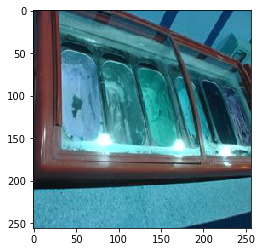

In [30]:
print_original(X_test[0], Y_test[0])

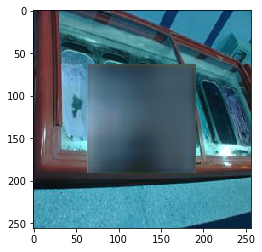

In [31]:
print_result(X_test[0])

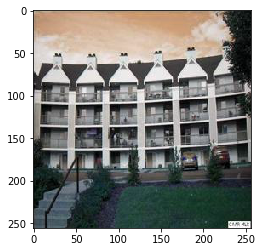

In [32]:
print_original(X_test[1], Y_test[1])

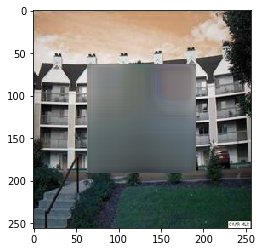

In [33]:
print_result(X_test[1])

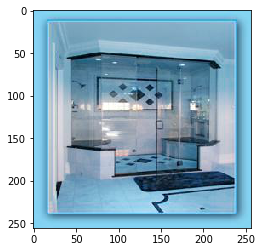

In [34]:
print_original(X_test[2], Y_test[2])

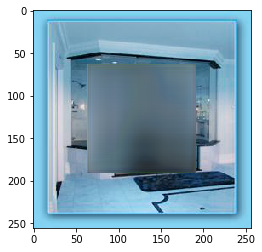

In [35]:
print_result(X_test[2])

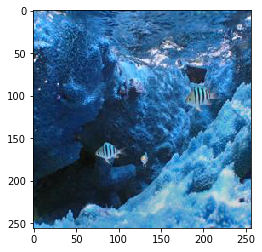

In [36]:
print_original(X_test[3], Y_test[3])

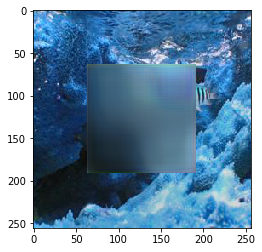

In [37]:
print_result(X_test[3])

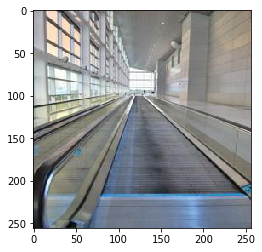

In [38]:
print_original(X_test[4], Y_test[4])

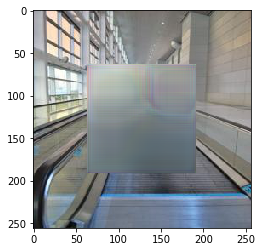

In [39]:
print_result(X_test[4])

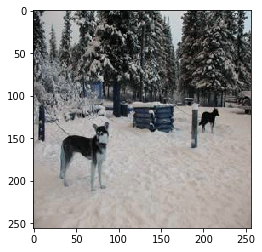

In [40]:
print_original(X_test[5], Y_test[5])

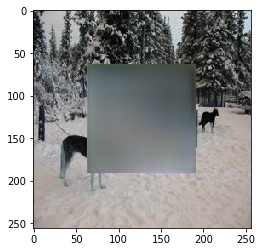

In [41]:
print_result(X_test[5])